# Advance lane finding
In the last two notebooks (4 & 5) we have looked at

* camera calibration and correcting distortion
* perspective transform
* gradient threshold
* color threshold

In this notebook, we go through a pipeline using above technique to detect lane line. The pipeline has following steps

1. camera calibration
2. distortion correction
3. color & gradient threshold: filter useful information
4. perspective transform: view image in a bird's eye view perspective
5. find the lines using **sliding-window-search**
6. measure curvature

First, let's import some modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

## Camera calibration & distortion correction
Let's start with camera calibration 

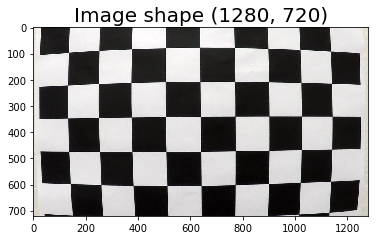

In [14]:
calib_imgs = glob.glob('CarND-P4-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
calib_imgs = np.sort(calib_imgs)
img0 = mpimg.imread(calib_imgs[0])

# get image shape
H, W, C = img0.shape
IMG_CV_SHAPE = (W, H)

_ = plt.imshow(img0)
_ = plt.title('Image shape {}'.format(IMG_CV_SHAPE), fontsize=20)

In [15]:
# find conners and draw conners on the image
def find_corners(bgr, nx, ny):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    #print (gray.shape, gray.shape[::-1])
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # cv2.drawChessboardCorners(rgb, (nx, ny), corners, ret)
    return ret, corners

def get_img_obj_points(imgs, nx, ny):
    imgs_points = []
    obj_points = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for img in imgs:
        bgr = cv2.imread(img)
        ret, conners = find_corners(bgr, nx, ny)
        if (ret):
            imgs_points.append(conners)
            obj_points.append(objp)
           
    return imgs_points, obj_points

Nx = 9
Ny = 5
# get imgs points, object points then calibrate
imgs_points, obj_points = get_img_obj_points(calib_imgs, Nx, Ny)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, imgs_points, IMG_CV_SHAPE, None, None)

In [18]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')

def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)

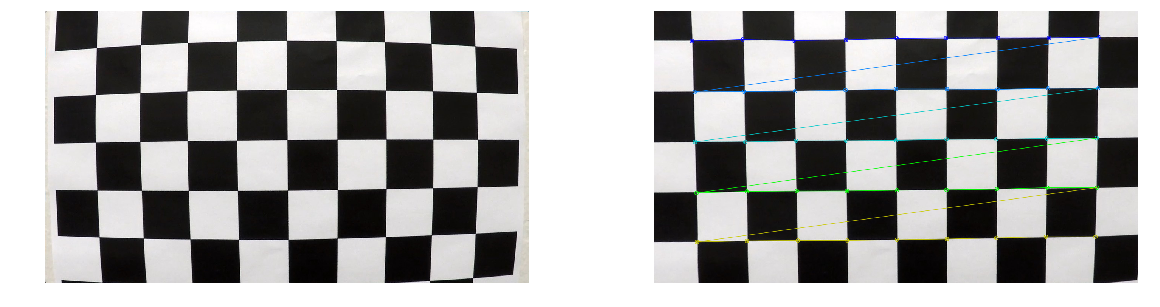

In [20]:
undist_img = cv2.undistort(img0, mtx, dist, None, mtx)
ret, corners = find_conners(undist_img, Nx, Ny)
cv2.drawChessboardCorners(undist_img, (Nx, Ny), corners, ret)
view_imgs([img0, undist_img], [None, None], (20,5))

## Gradient and color threshold
Next we will use gradient/color threshold to create binary image.

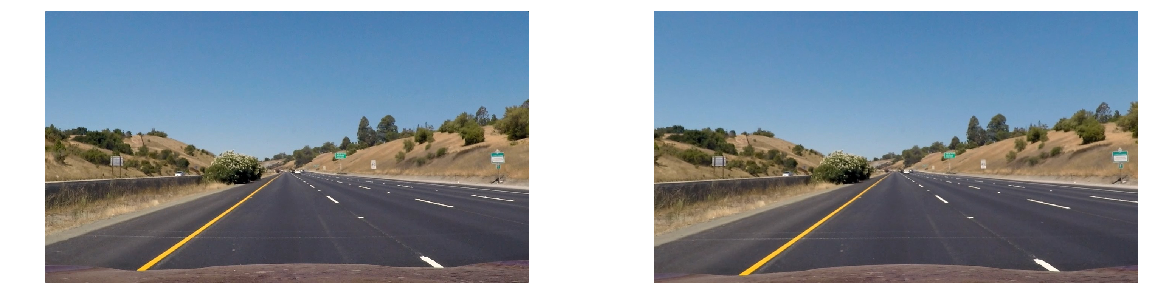

In [27]:
# Get road files
road_files = glob.glob('./CarND-P4-Advanced-Lane-Lines/test_images/*.jpg')
road_files = np.sort(road_imgs)

# Load and correct it
road0 = mpimg.imread(road_files[0])
undist_road0 = cv2.undistort(road0, mtx, dist, None, mtx)

# Visualize it
view_imgs([road0, undist_road0], [None, None], (20,5))

We implement the following threshold functions
* absolute Sobel threshold in x/y
* magniture Sobel threshold
* direction threshold
* color threshold using S-channel

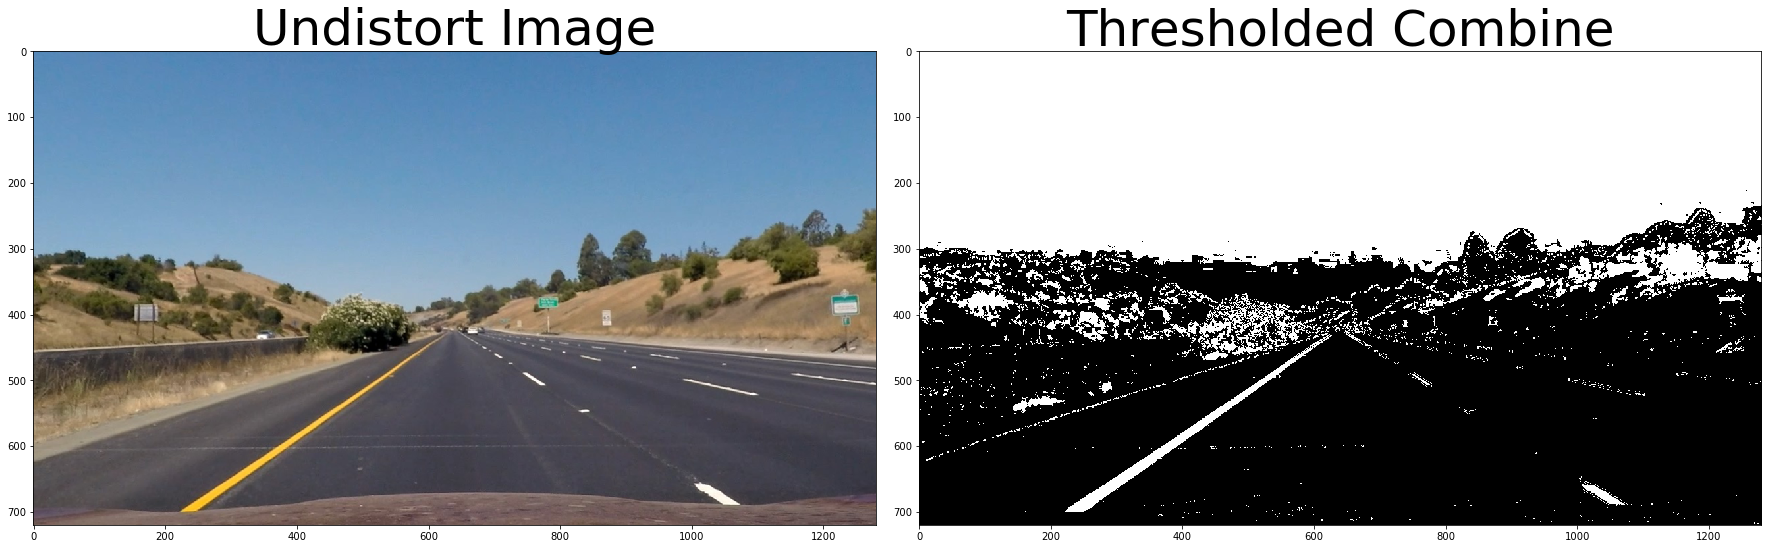

In [34]:
def abs_sobel_thresh(img_channel, sobel_kernel=3, orient='x', thresh = (0,255)):
    '''
    absolute Sobel threshold in a specific direction
    args: 
        img_channel: is a channel of the image (e.g grayscale channel or S channel e.t.c)
    '''
    if orient == 'x':
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255. * sobel / np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    magniture threshold sqrt(sobolx^2 + soboly^2)
    args:
        img_channel: is a channel of the image
    '''
    sobelx = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    magn = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_magn = np.uint8(255*magn/np.max(magn))
    
    binary_output = np.zeros_like(magn)
    binary_output[(scaled_magn >= mag_thresh[0]) & (scaled_magn <= mag_thresh[1])] = 1
    
    return binary_output

def dir_thresh(img_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

def color_thresh(img_channel, thresh = (0,255)):
    binary_output = np.zeros_like(img_channel)
    binary_output[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary_output

def combined_threshold(img_rgb, ksize=3):
    
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    color_bin = color_thresh(hls[:,:,2], thresh=(90, 255))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_bin==1)] = 1
    return combined

undist_road0_bin = combined_threshold(undist_road0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_road0)
ax1.set_title('Undistort Image', fontsize=50)
ax2.imshow(undist_road0_bin, cmap='gray')
ax2.set_title('Thresholded Combine', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform
The next step is to define four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective

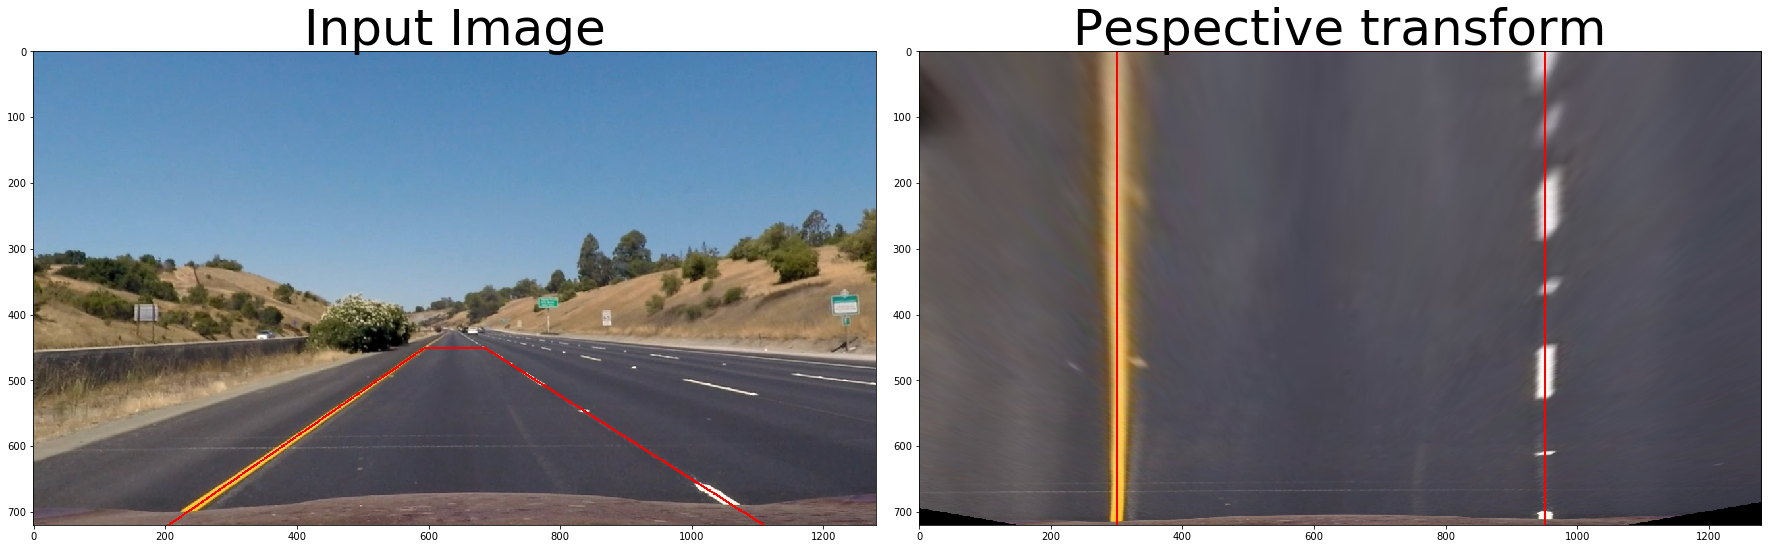

In [68]:
src_points = np.float32([(205, 720), (595,450), (685,450), (1110,720)])
dst_points = np.float32([(300, 720), (300, 0),  (950, 0),  (950, 720)])

def view_presp_trans(in_img, src_points, dst_points, cmap=None):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    img = np.copy(in_img)
    warped = cv2.warpPerspective(img, M, IMG_CV_SHAPE, flags=cv2.INTER_LINEAR) 
    
    if (cmap==None):
        for i in range(3):
            cv2.line(img,    tuple(src_points[i]), tuple(src_points[i+1]), color=[255, 0, 0], thickness=2)
            cv2.line(warped, tuple(dst_points[i]), tuple(dst_points[i+1]), color=[255, 0, 0], thickness=2)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Input Image', fontsize=50)
    ax2.imshow(warped, cmap=cmap)
    ax2.set_title('Pespective transform', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
view_presp_trans(undist_road0, src_points, dst_points)

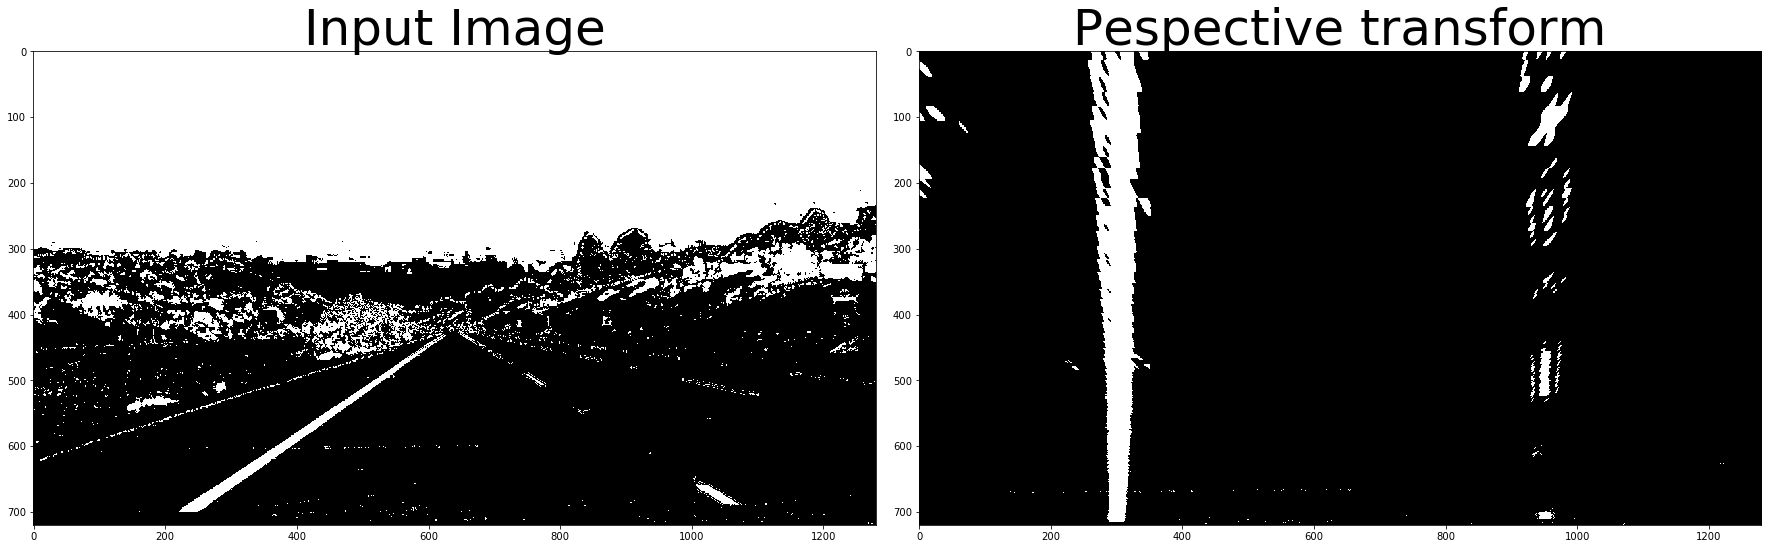

In [69]:
view_presp_trans(undist_road0_bin, src_points, dst_points, cmap='gray')
#plt.imshow(undist_road0_bin, cmap='gray')

The perspective transform looks reasonable, so from now on we always use the same perspective transform defined in `P_M`

In [70]:
P_M = cv2.getPerspectiveTransform(src_points, dst_points)

## Finding the lines using sliding-window-search
Now, we will use the **sliding-window-search** technique to find the line. There are two approaches (all learnt from the project page)
* first one using histogram
* second one using convolution